## Feature engineering

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# -----------------------------------------------------------------------------
# 1) Load & preprocess (as before)
# -----------------------------------------------------------------------------
def load_and_preprocess(path):
    df = pd.read_parquet(path)
    df.sort_values(["coin_id","timestamp"], inplace=True)
    df["target_direction"] = (
        df.groupby("coin_id", observed=True)["close"]
          .transform(lambda x: (x.shift(-1) > x).astype(int))
    )
    df.dropna(subset=["target_direction"], inplace=True)
    return df

# -----------------------------------------------------------------------------
# 2) Feature engineering
# -----------------------------------------------------------------------------
def add_features(df):
    df = df.copy().sort_values(["coin_id","timestamp"])
    
    # 2.1) volume ratio
    df["volume_ratio"] = df["taker_buy_quote_asset_volume"] / df["quote_asset_volume"]
    
    # 2.2) turn timestamp into index for rolling
    df.set_index("timestamp", inplace=True)
    
    # 2.3) log returns and range features
    df["log_ret"]   = df.groupby("coin_id")["close"].transform(lambda x: np.log(x).diff())
    df["range_pct"] = (df["high"] - df["low"]) / df["open"]
    df["oc_pct"]    = (df["close"] - df["open"]) / df["open"]
    
    # 2.4) moving averages and momentum
    df["sma_10"] = df.groupby("coin_id")["close"].transform(lambda x: x.rolling(10).mean())
    df["ema_10"] = df.groupby("coin_id")["close"].transform(lambda x: x.ewm(span=10,adjust=False).mean())
    
    # 2.5) rolling volatility & momentum over multiple windows
    windows = [5,10,20,50,100]
    for w in windows:
        df[f"ret_ma_{w}"] = df.groupby("coin_id")["log_ret"].transform(lambda x: x.rolling(w).mean())
        df[f"vol_{w}"]    = df.groupby("coin_id")["log_ret"].transform(lambda x: x.rolling(w).std())
    # momentum difference short vs long
    df["mom_diff_5_50"] = df["ret_ma_5"] - df["ret_ma_50"]
    
    # 2.6) simple trend ratio
    df["sma_7"]  = df.groupby("coin_id")["close"].transform(lambda x: x.rolling(7).mean())
    df["sma_30"] = df.groupby("coin_id")["close"].transform(lambda x: x.rolling(30).mean())
    df["trend_ratio"] = df["sma_7"] / df["sma_30"]
    
    # 2.7) Fourier features for daily & weekly seasonality
    #    convert index to seconds
    sec = df.index.view(int) // 10**9
    day  = 24*60*60
    week = 7*day
    df["sin_day"] = np.sin(2*np.pi*sec/day)
    df["cos_day"] = np.cos(2*np.pi*sec/day)
    df["sin_week"]= np.sin(2*np.pi*sec/week)
    df["cos_week"]= np.cos(2*np.pi*sec/week)
    
    # 2.8) reset index
    df.reset_index(inplace=True)
    return df

# -----------------------------------------------------------------------------
# 3) Full pipeline: apply above, then scale per‐coin
# -----------------------------------------------------------------------------
intervals = ["10min","1h","4h","1d"]
train_feats, test_feats = {}, {}

for iv in intervals:
    print(f"--- {iv} ---")
    tr = load_and_preprocess(f"data/resampled/train_{iv}.parquet")
    te = load_and_preprocess(f"data/resampled/test_{iv}.parquet")
    
    # 3.1) add features
    tr_feat = add_features(tr)
    te_feat = add_features(te)
    
    # 3.2) pick numeric columns (exclude IDs & target)
    feat_cols = [
        c for c in tr_feat.select_dtypes("number").columns
        if c not in ("target_direction",)
    ]
    
    # 3.3) per‐coin scaling
    for coin in tr_feat["coin_id"].unique():
        mask_tr = tr_feat["coin_id"] == coin
        scaler  = StandardScaler().fit(tr_feat.loc[mask_tr, feat_cols])
        tr_feat.loc[mask_tr, feat_cols] = scaler.transform(tr_feat.loc[mask_tr, feat_cols])
        
        mask_te = te_feat["coin_id"] == coin
        if mask_te.any():
            te_feat.loc[mask_te, feat_cols] = scaler.transform(te_feat.loc[mask_te, feat_cols])
    
    # 3.4) drop any remaining NaNs
    tr_feat = tr_feat.dropna(subset=feat_cols + ["target_direction"]).reset_index(drop=True)
    te_feat = te_feat.dropna(subset=feat_cols + ["target_direction"]).reset_index(drop=True)
    
    train_feats[iv] = tr_feat
    test_feats [iv] = te_feat
    print(f"{iv}: train={tr_feat.shape}, test={te_feat.shape}")

--- 10min ---
10min: train=(896735, 36), test=(237195, 36)
--- 1h ---
1h: train=(149060, 36), test=(39120, 36)
--- 4h ---
4h: train=(36910, 36), test=(9405, 36)
--- 1d ---
1d: train=(5735, 36), test=(1155, 36)


## Logistic regression


=== Interval: 10min ===

-- Coin: BNBUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.54      0.13      0.21     23977
           1       0.50      0.88      0.64     23462

    accuracy                           0.50     47439
   macro avg       0.52      0.51      0.42     47439
weighted avg       0.52      0.50      0.42     47439

Test ROC AUC: 0.517456225017904


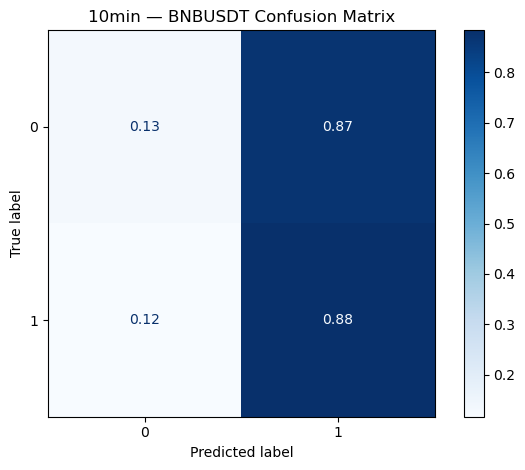


-- Coin: BTCUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.52      0.57      0.54     23698
           1       0.52      0.47      0.49     23741

    accuracy                           0.52     47439
   macro avg       0.52      0.52      0.52     47439
weighted avg       0.52      0.52      0.52     47439

Test ROC AUC: 0.528841722233191


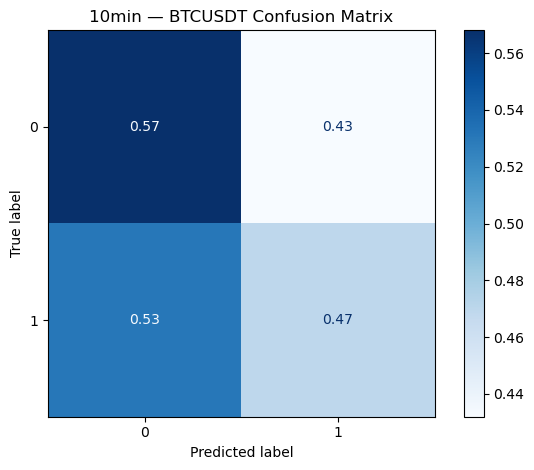


-- Coin: ETHUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.53      0.28      0.37     23558
           1       0.51      0.75      0.61     23881

    accuracy                           0.52     47439
   macro avg       0.52      0.52      0.49     47439
weighted avg       0.52      0.52      0.49     47439

Test ROC AUC: 0.5250015162945055


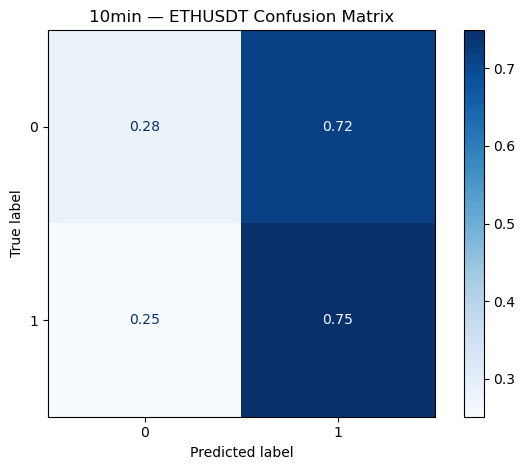


-- Coin: SOLUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.53      0.27      0.36     23925
           1       0.50      0.76      0.61     23514

    accuracy                           0.51     47439
   macro avg       0.52      0.51      0.48     47439
weighted avg       0.52      0.51      0.48     47439

Test ROC AUC: 0.5212412641251807


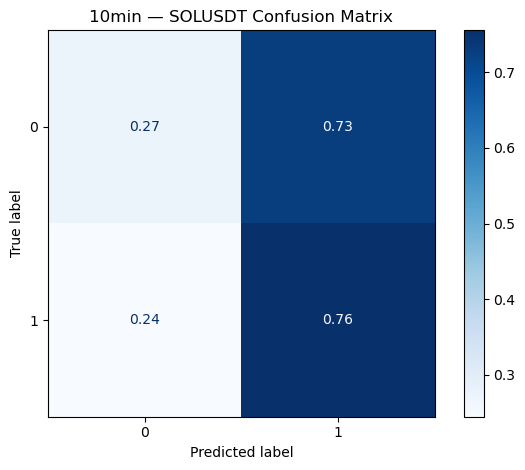


-- Coin: XRPUSDT --


/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best C: 10.0
              precision    recall  f1-score   support

           0       0.53      0.54      0.54     24278
           1       0.51      0.50      0.50     23161

    accuracy                           0.52     47439
   macro avg       0.52      0.52      0.52     47439
weighted avg       0.52      0.52      0.52     47439

Test ROC AUC: 0.5303776937903619


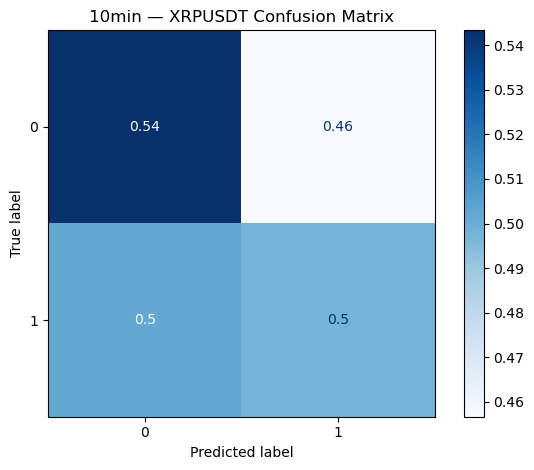


=== Interval: 1h ===

-- Coin: BNBUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.52      0.47      0.50      3832
           1       0.54      0.59      0.56      3992

    accuracy                           0.53      7824
   macro avg       0.53      0.53      0.53      7824
weighted avg       0.53      0.53      0.53      7824

Test ROC AUC: 0.5418902130984307


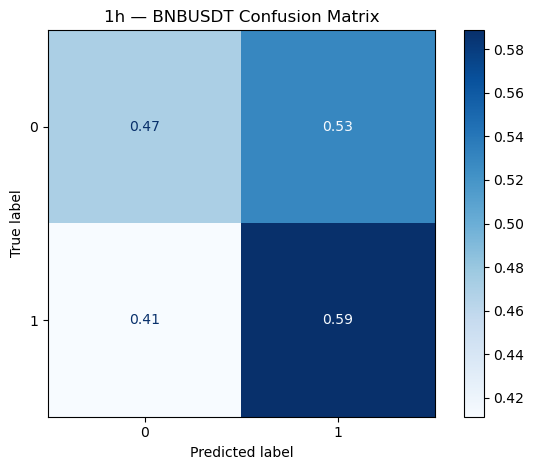


-- Coin: BTCUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.53      0.50      0.52      3864
           1       0.54      0.58      0.56      3960

    accuracy                           0.54      7824
   macro avg       0.54      0.54      0.54      7824
weighted avg       0.54      0.54      0.54      7824

Test ROC AUC: 0.5501355427985863


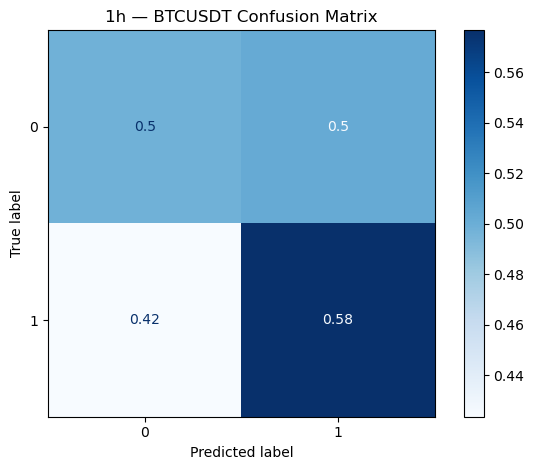


-- Coin: ETHUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.54      0.46      0.50      3901
           1       0.53      0.60      0.57      3923

    accuracy                           0.53      7824
   macro avg       0.53      0.53      0.53      7824
weighted avg       0.53      0.53      0.53      7824

Test ROC AUC: 0.5508696208734363


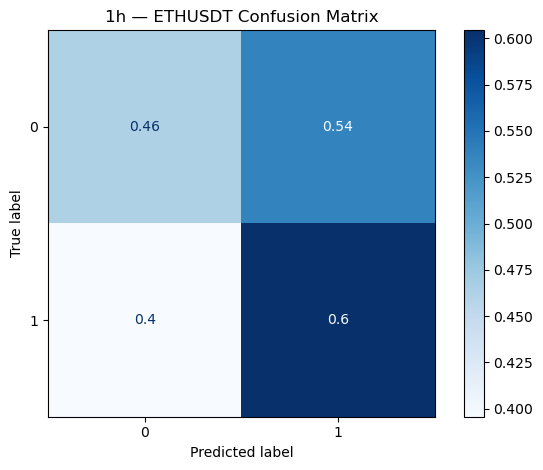


-- Coin: SOLUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.53      0.50      0.51      3895
           1       0.53      0.57      0.55      3929

    accuracy                           0.53      7824
   macro avg       0.53      0.53      0.53      7824
weighted avg       0.53      0.53      0.53      7824

Test ROC AUC: 0.5429137407206411


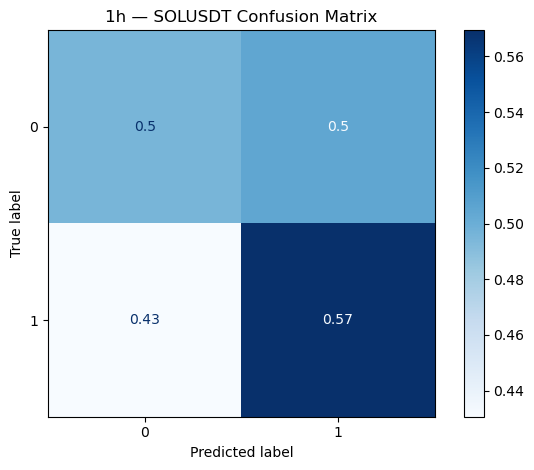


-- Coin: XRPUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.52      0.62      0.57      3886
           1       0.54      0.43      0.48      3938

    accuracy                           0.53      7824
   macro avg       0.53      0.53      0.52      7824
weighted avg       0.53      0.53      0.52      7824

Test ROC AUC: 0.5359836994777779


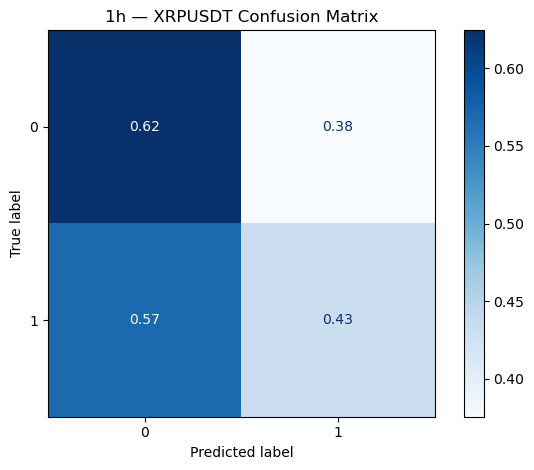


=== Interval: 4h ===

-- Coin: BNBUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.52      0.77      0.62       933
           1       0.58      0.30      0.40       948

    accuracy                           0.54      1881
   macro avg       0.55      0.54      0.51      1881
weighted avg       0.55      0.54      0.51      1881

Test ROC AUC: 0.5515136508970202


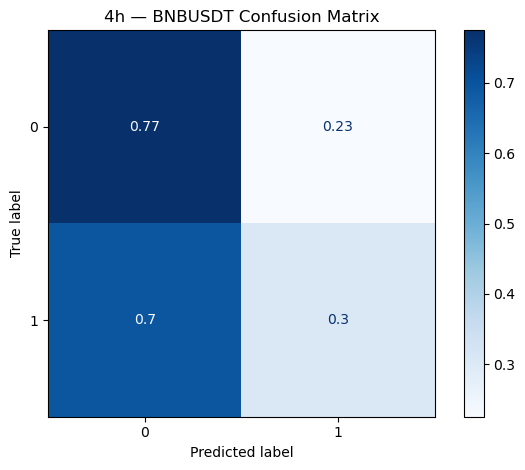


-- Coin: BTCUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.52      0.42      0.47       907
           1       0.54      0.63      0.58       974

    accuracy                           0.53      1881
   macro avg       0.53      0.53      0.52      1881
weighted avg       0.53      0.53      0.53      1881

Test ROC AUC: 0.550550249145931


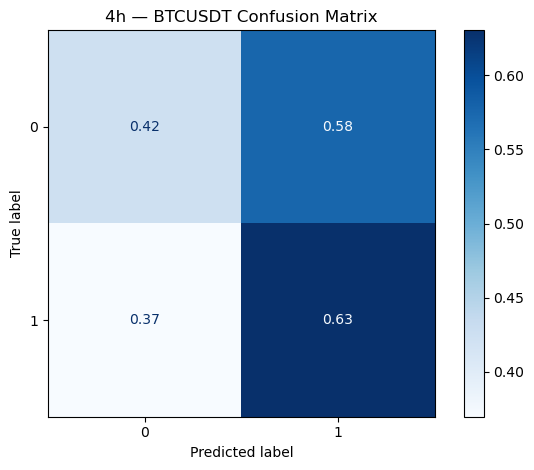


-- Coin: ETHUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.51      0.18      0.26       944
           1       0.50      0.83      0.62       937

    accuracy                           0.50      1881
   macro avg       0.50      0.50      0.44      1881
weighted avg       0.50      0.50      0.44      1881

Test ROC AUC: 0.5241349058480907


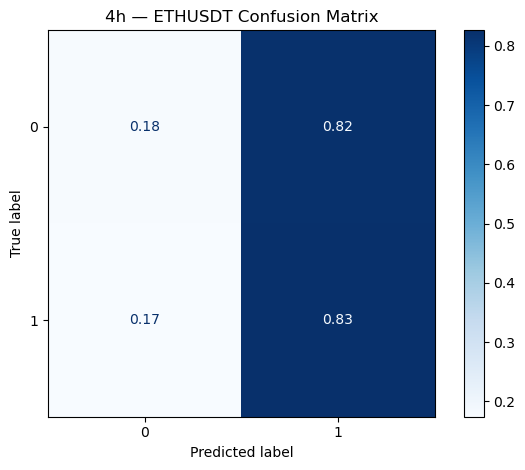


-- Coin: SOLUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.50      0.86      0.63       930
           1       0.55      0.18      0.27       951

    accuracy                           0.51      1881
   macro avg       0.53      0.52      0.45      1881
weighted avg       0.53      0.51      0.45      1881

Test ROC AUC: 0.5251766674581368


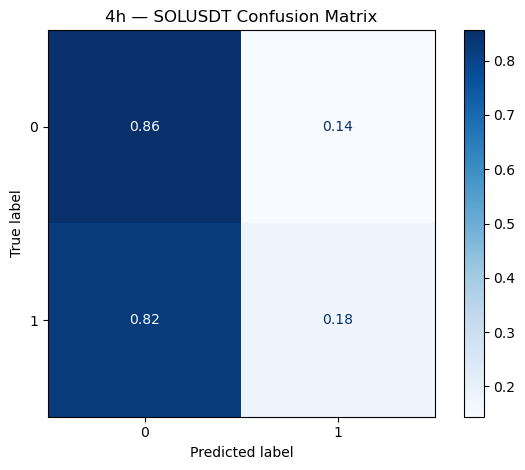


-- Coin: XRPUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.49      0.70      0.58       926
           1       0.50      0.29      0.37       955

    accuracy                           0.49      1881
   macro avg       0.50      0.50      0.47      1881
weighted avg       0.50      0.49      0.47      1881

Test ROC AUC: 0.48818992909886577


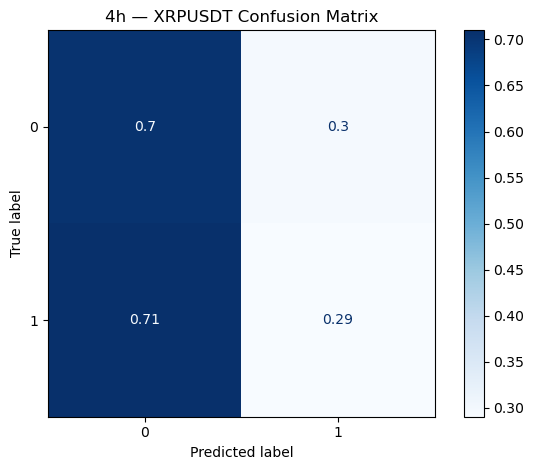


=== Interval: 1d ===

-- Coin: BNBUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.50      0.80      0.61       111
           1       0.58      0.25      0.35       120

    accuracy                           0.52       231
   macro avg       0.54      0.53      0.48       231
weighted avg       0.54      0.52      0.48       231

Test ROC AUC: 0.5466216216216215


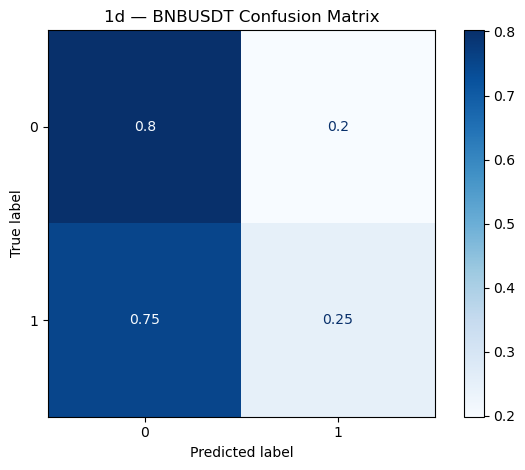


-- Coin: BTCUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.48      0.70      0.57       111
           1       0.52      0.30      0.38       120

    accuracy                           0.49       231
   macro avg       0.50      0.50      0.48       231
weighted avg       0.50      0.49      0.47       231

Test ROC AUC: 0.4975975975975976


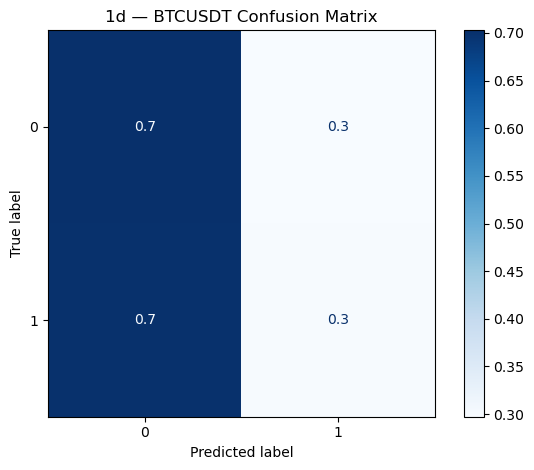


-- Coin: ETHUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       115
           1       0.50      1.00      0.67       116

    accuracy                           0.50       231
   macro avg       0.25      0.50      0.33       231
weighted avg       0.25      0.50      0.34       231

Test ROC AUC: 0.521664167916042


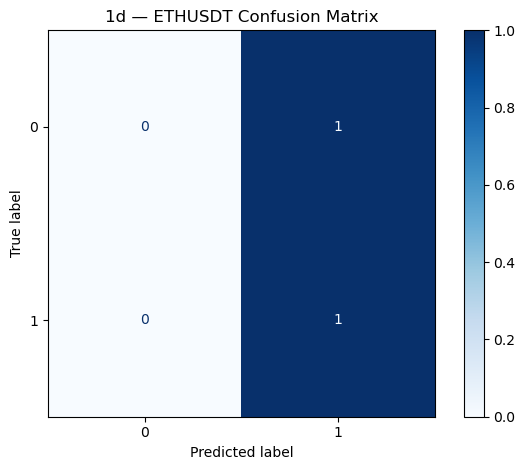


-- Coin: SOLUSDT --
Best C: 10.0
              precision    recall  f1-score   support

           0       0.68      0.17      0.27       115
           1       0.53      0.92      0.67       116

    accuracy                           0.55       231
   macro avg       0.60      0.54      0.47       231
weighted avg       0.60      0.55      0.47       231

Test ROC AUC: 0.5394302848575712


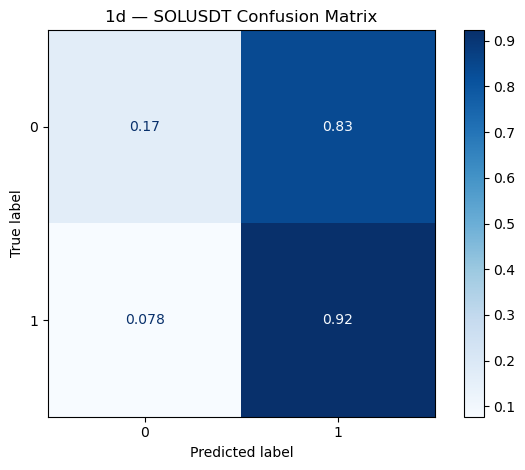


-- Coin: XRPUSDT --
Best C: 0.1
              precision    recall  f1-score   support

           0       0.49      0.91      0.63       108
           1       0.66      0.15      0.25       123

    accuracy                           0.51       231
   macro avg       0.57      0.53      0.44       231
weighted avg       0.58      0.51      0.43       231

Test ROC AUC: 0.5101626016260162


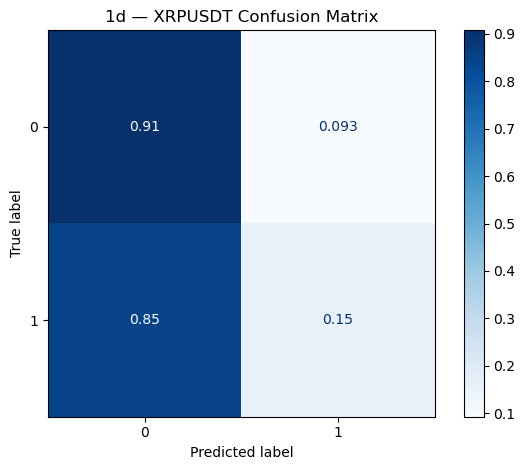

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

# 1) Intervals and feature list (assumes train_feats/test_feats dicts exist)
intervals = ["10min", "1h", "4h", "1d"]
# pick feature columns once (same set for all intervals)
feature_cols = [
    c for c in train_feats["10min"].columns
    if c not in ("coin_id", "timestamp", "target_direction")
]

# 2) CV splitter and hyperparameter grid
tscv      = TimeSeriesSplit(n_splits=5)
param_grid = {"C": [0.1, 1.0, 10.0]}

# 3) Main loop: interval → coin
for iv in intervals:
    print(f"\n=== Interval: {iv} ===")
    # drop any rows with missing features/target
    tr_df = train_feats[iv].dropna(subset=feature_cols + ["target_direction"])
    te_df = test_feats [iv].dropna(subset=feature_cols + ["target_direction"])
    
    for coin in tr_df["coin_id"].unique():
        print(f"\n-- Coin: {coin} --")
        # subset per coin
        tr = tr_df[tr_df["coin_id"] == coin]
        te = te_df[te_df["coin_id"] == coin]
        
        X_train = tr[feature_cols]
        y_train = tr["target_direction"]
        X_test  = te[feature_cols]
        y_test  = te["target_direction"]
        
        # 3a) Grid‐search over regularization strength
        base_clf = LogisticRegression(
            class_weight="balanced",
            solver="liblinear",
            max_iter=1000
        )
        grid = GridSearchCV(
            base_clf,
            param_grid=param_grid,
            cv=tscv,
            scoring="roc_auc",
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best = grid.best_estimator_
        print("Best C:", grid.best_params_["C"])
        
        # 3b) Evaluate on the test set
        y_pred  = best.predict(X_test)
        y_proba = best.predict_proba(X_test)[:,1]
        
        print(classification_report(y_test, y_pred, zero_division=0))
        print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
        
        # 3c) Plot normalized confusion matrix
        disp = ConfusionMatrixDisplay.from_predictions(
            y_test, y_pred, normalize="true", cmap="Blues"
        )
        disp.ax_.set_title(f"{iv} — {coin} Confusion Matrix")
        plt.tight_layout()
        plt.show()

## P&L backtest & equal-weight portfolio


=== P&L Backtest @ 10min ===


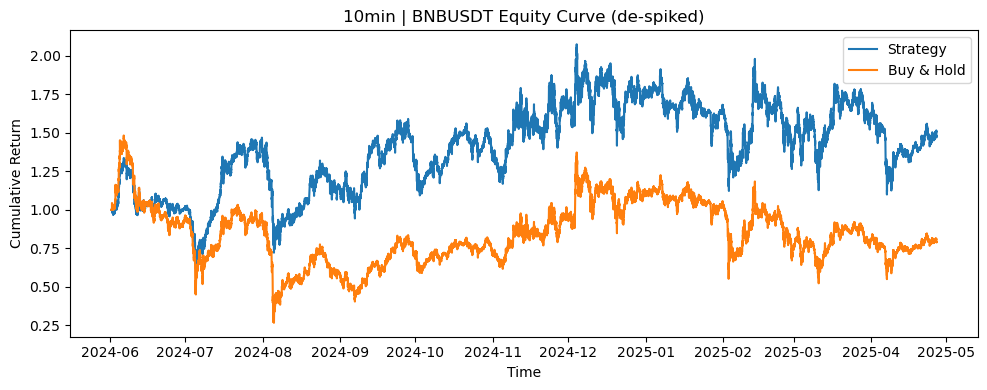

BNBUSDT  Strategy = 47.91%   B&H = -20.63%   Sharpe = 0.97


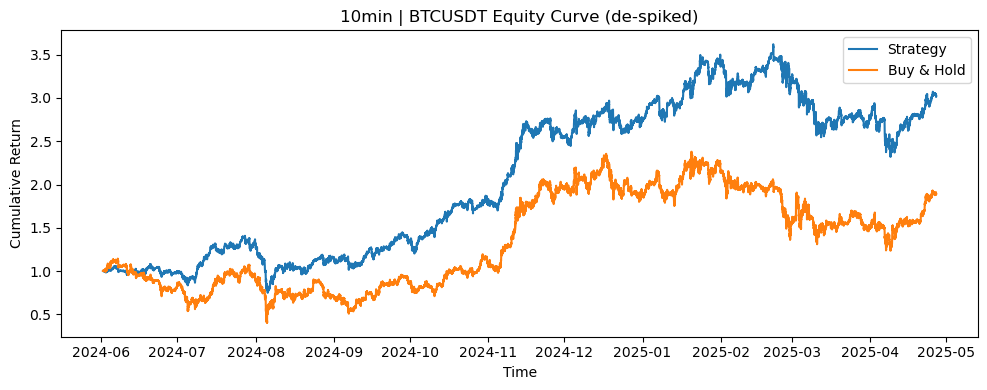

BTCUSDT  Strategy = 201.98%   B&H = 88.95%   Sharpe = 2.08


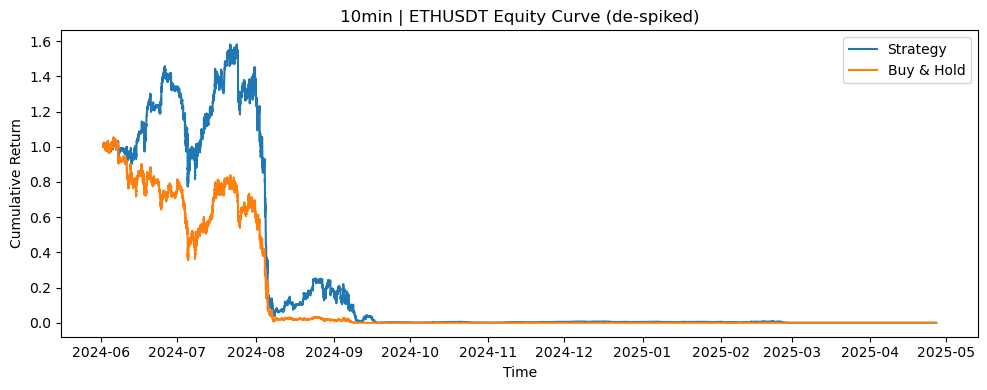

ETHUSDT  Strategy = -100.00%   B&H = -100.00%   Sharpe = 0.15


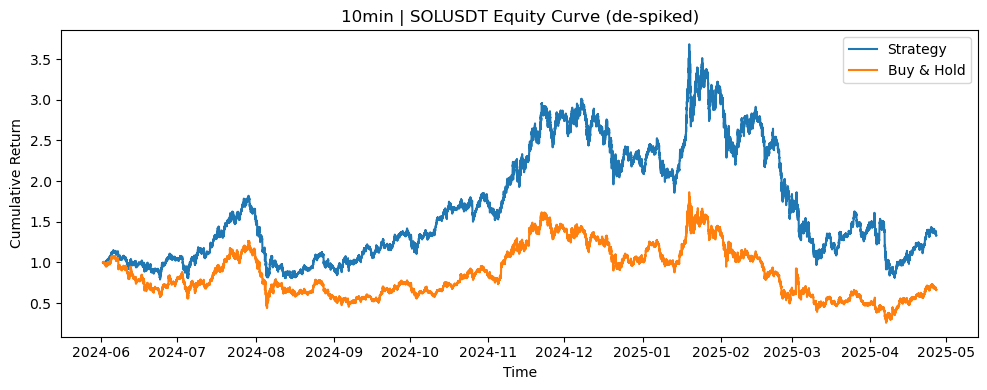

SOLUSDT  Strategy = 33.78%   B&H = -33.63%   Sharpe = 0.89


/opt/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


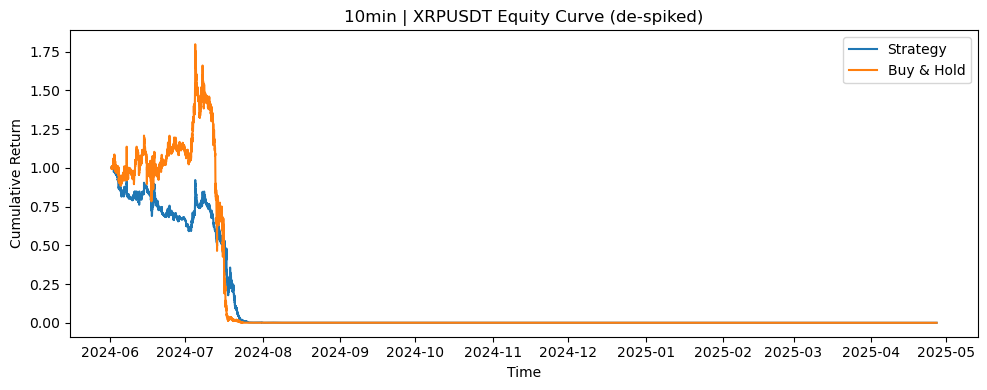

XRPUSDT  Strategy = -100.00%   B&H = -100.00%   Sharpe = -2.41

=== P&L Backtest @ 1h ===


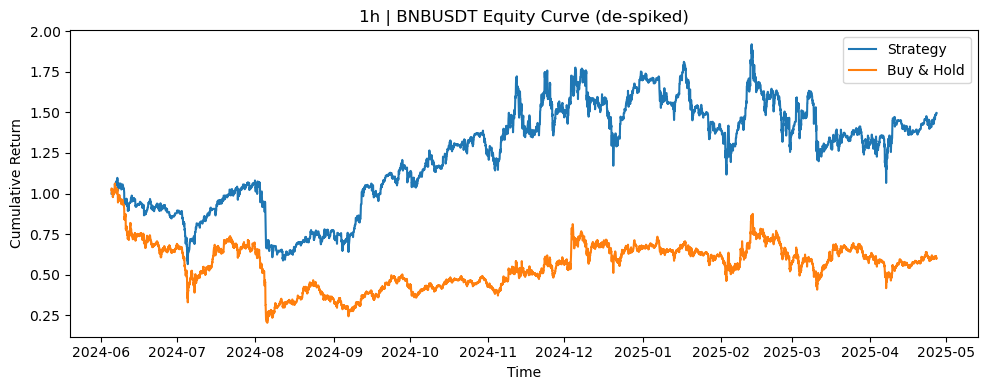

BNBUSDT  Strategy = 49.70%   B&H = -39.81%   Sharpe = 0.95


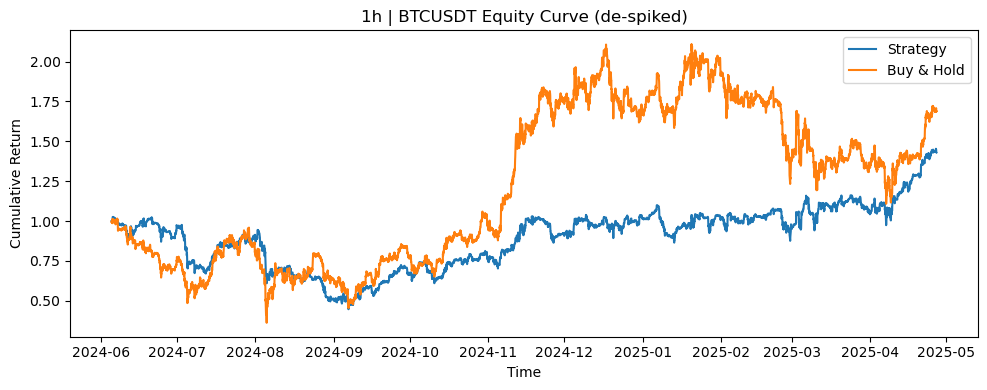

BTCUSDT  Strategy = 42.96%   B&H = 69.07%   Sharpe = 0.91


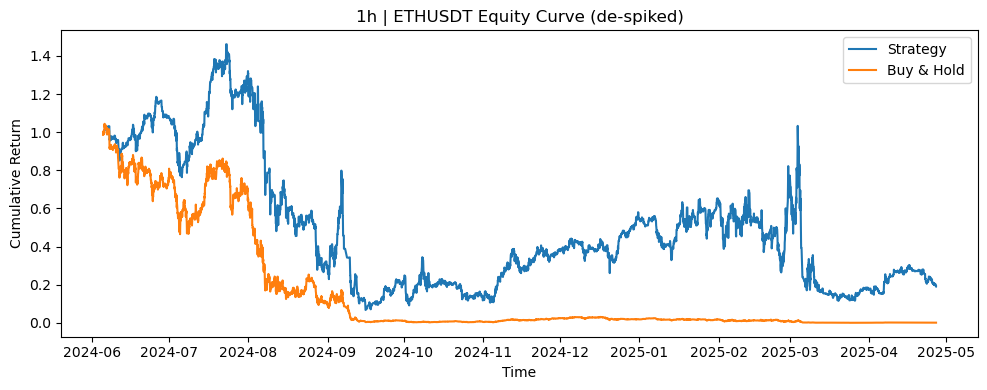

ETHUSDT  Strategy = -80.92%   B&H = -99.87%   Sharpe = 0.89


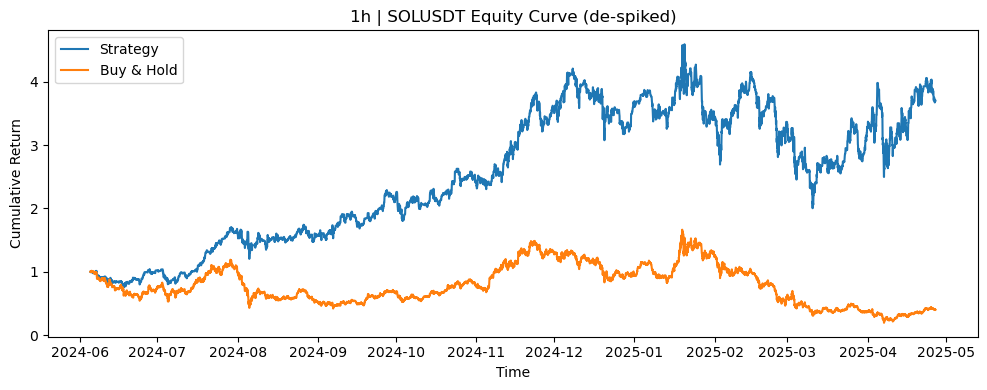

SOLUSDT  Strategy = 270.17%   B&H = -60.11%   Sharpe = 1.86


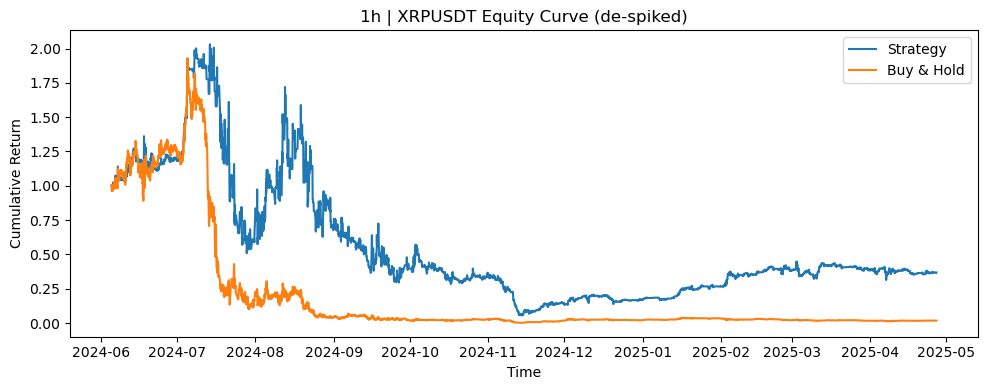

XRPUSDT  Strategy = -63.20%   B&H = -98.27%   Sharpe = 0.74

=== P&L Backtest @ 4h ===


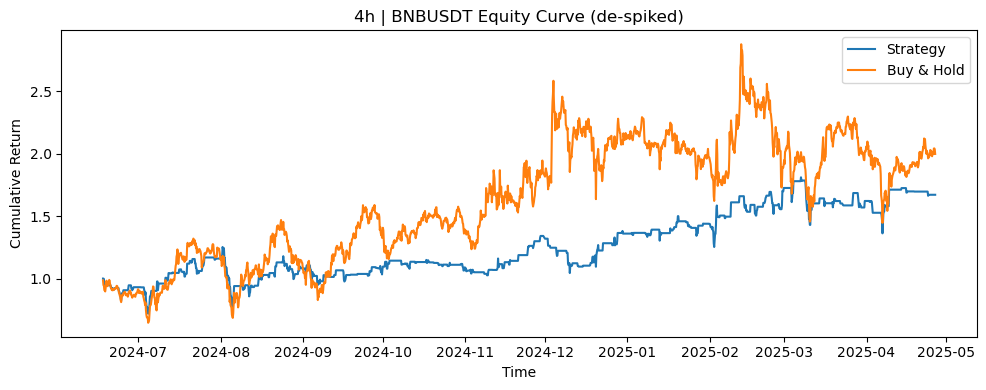

BNBUSDT  Strategy = 67.14%   B&H = 99.86%   Sharpe = 1.20


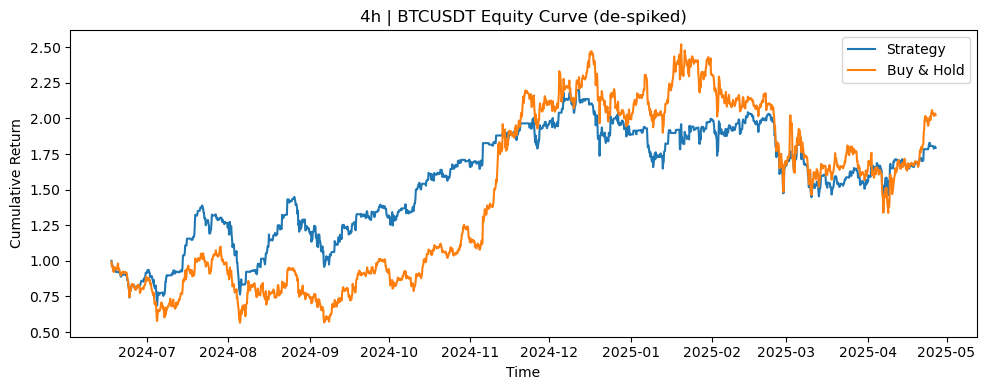

BTCUSDT  Strategy = 79.31%   B&H = 102.38%   Sharpe = 1.23


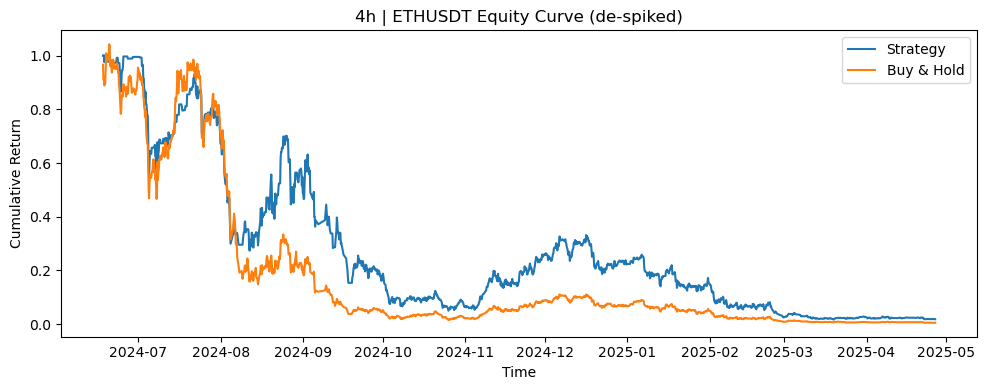

ETHUSDT  Strategy = -98.20%   B&H = -99.53%   Sharpe = -0.62


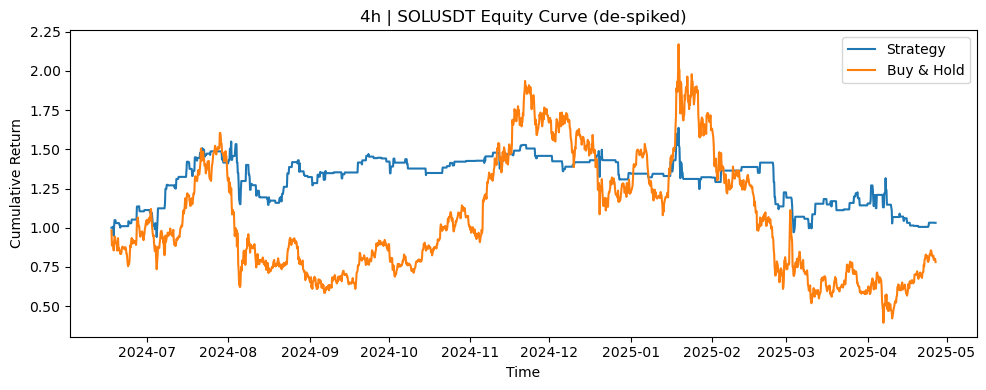

SOLUSDT  Strategy = 3.14%   B&H = -21.91%   Sharpe = 0.38


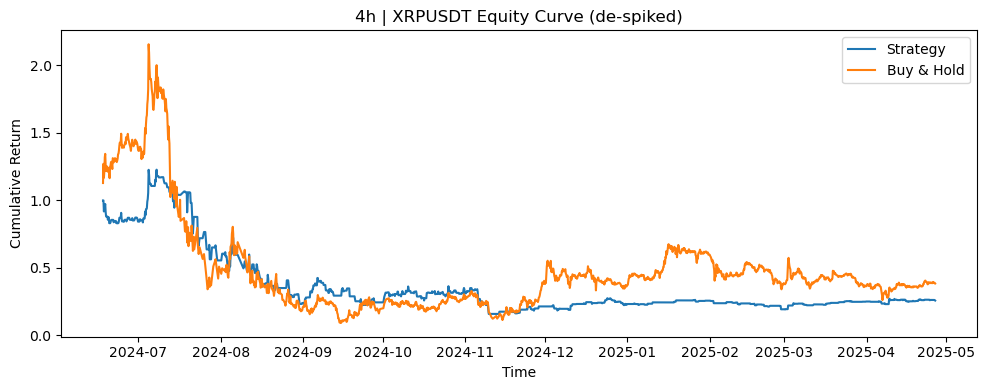

XRPUSDT  Strategy = -74.17%   B&H = -61.56%   Sharpe = -0.41

=== P&L Backtest @ 1d ===


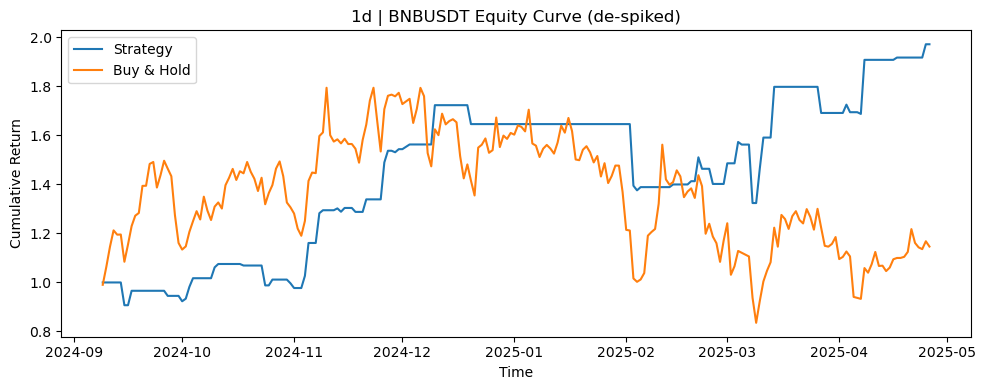

BNBUSDT  Strategy = 97.14%   B&H = 14.64%   Sharpe = 2.18


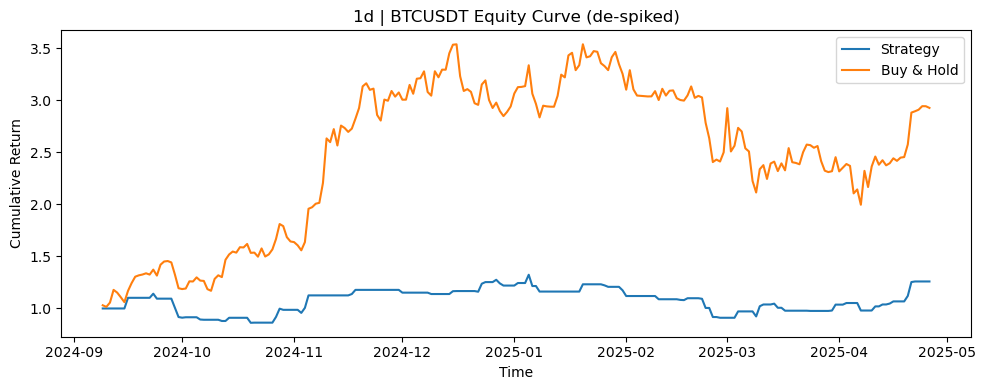

BTCUSDT  Strategy = 25.93%   B&H = 192.56%   Sharpe = 0.98


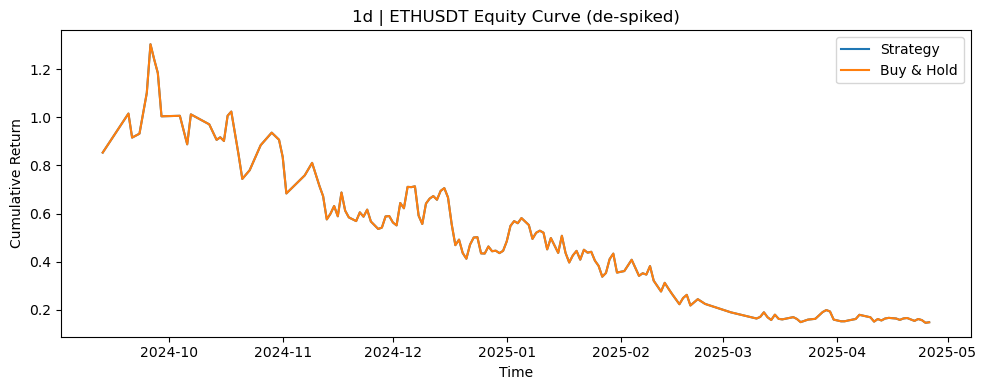

ETHUSDT  Strategy = -85.23%   B&H = -85.23%   Sharpe = -1.50


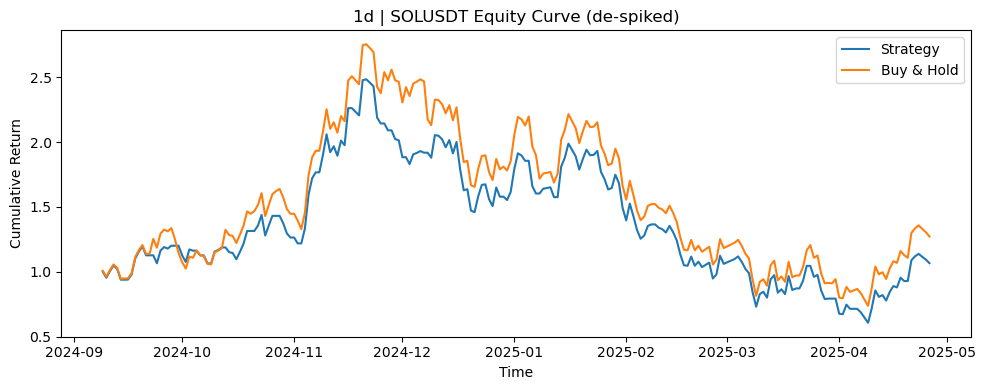

SOLUSDT  Strategy = 6.64%   B&H = 27.25%   Sharpe = 0.68


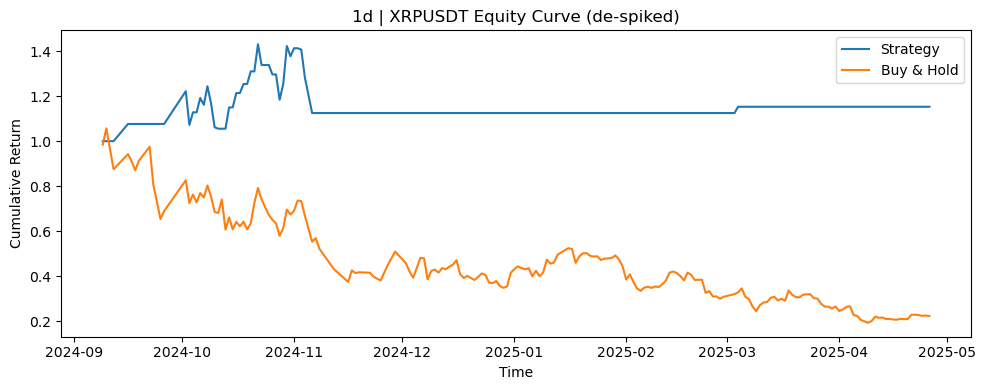

XRPUSDT  Strategy = 15.29%   B&H = -77.77%   Sharpe = 0.76

=== Equal-Weight Portfolio Backtest ===

--- Interval: 10min ---


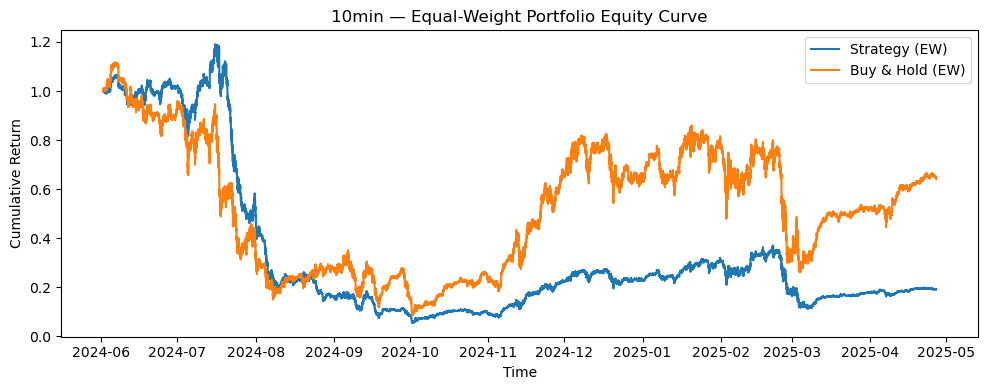

EW Portfolio: Strategy = -80.85%, B&H = -35.86%, Sharpe = -0.64

--- Interval: 1h ---


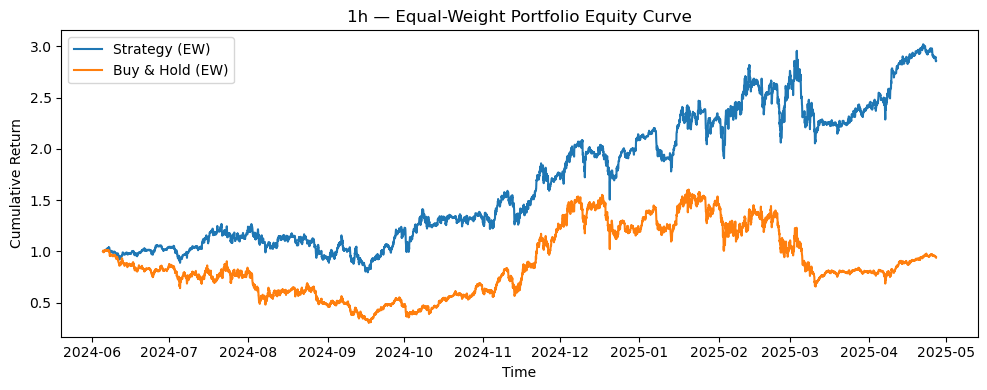

EW Portfolio: Strategy = 185.83%, B&H = -6.02%, Sharpe = 1.72

--- Interval: 4h ---


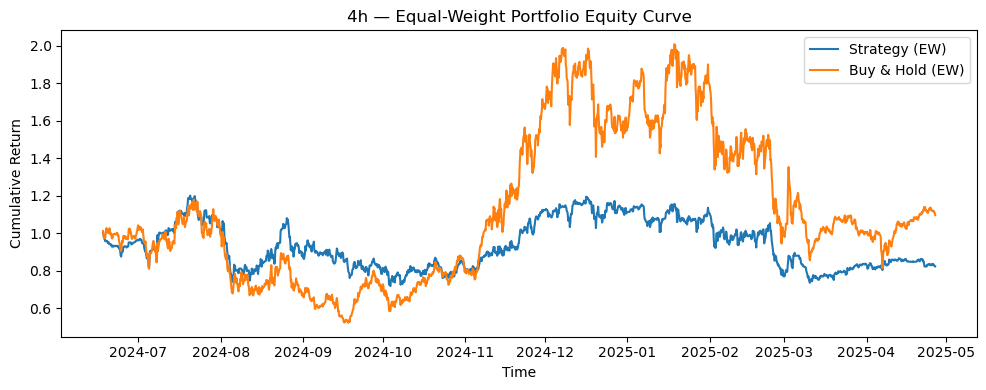

EW Portfolio: Strategy = -17.74%, B&H = 9.68%, Sharpe = 0.02

--- Interval: 1d ---


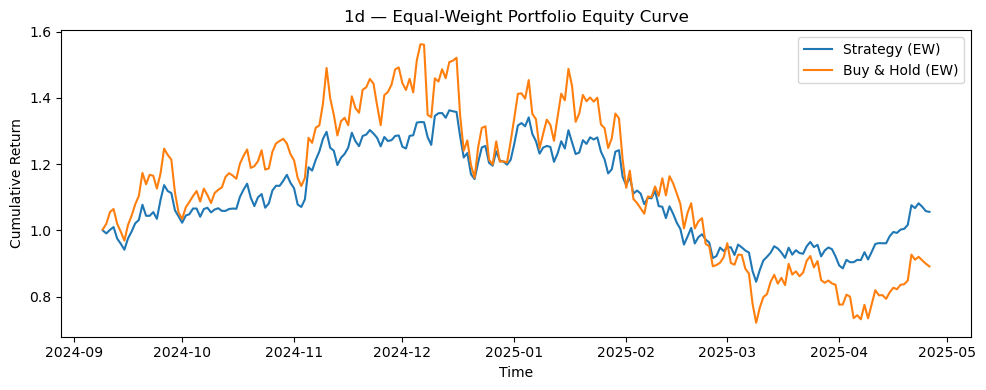

EW Portfolio: Strategy = 5.60%, B&H = -10.89%, Sharpe = 0.42


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mstats
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

# 0) Annualization factors for Sharpe ratio
periods_per_year = {"10min": 365*24*6, "1h": 365*24, "4h": 365*6, "1d": 365}

# Pre-allocate storage: backtest DataFrames for each interval/coin
backtests = {iv: {} for iv in intervals}

# 1) Single-coin backtest loop: populate backtests
for iv in intervals:
    print(f"\n=== P&L Backtest @ {iv} ===")
    for coin in train_feats[iv]["coin_id"].unique():
        # 1.1) Split into train/test sets
        tr = train_feats[iv].query("coin_id == @coin")
        te = test_feats[iv].query("coin_id == @coin")
        tr = tr.dropna(subset=feature_cols + ["target_direction"])
        te = te.dropna(subset=feature_cols + ["target_direction"])
        if tr.empty or te.empty:
            print(f"{coin}: no data, skipping")
            continue

        # 1.2) Fit on the entire training set and select C via grid search
        X_tr, y_tr = tr[feature_cols], tr["target_direction"]
        grid = GridSearchCV(
            LogisticRegression(class_weight="balanced", solver="liblinear", max_iter=1000),
            param_grid=param_grid, cv=tscv, scoring="roc_auc", n_jobs=-1
        )
        grid.fit(X_tr, y_tr)
        clf = grid.best_estimator_

        # 1.3) Generate signals and raw bar returns
        df = te.copy().sort_values("timestamp").reset_index(drop=True)
        df["signal"]  = clf.predict(df[feature_cols])
        # shift signal by 1 bar so we act on the next bar
        df["signal"]  = df["signal"].shift(1).fillna(0).astype(int)
        df["bar_ret"] = df["close"].pct_change().shift(-1)
        df.dropna(subset=["bar_ret"], inplace=True)

        # 1.4) Remove extreme jumps (>20%)
        max_bar_jump = 0.20
        df = df[df["bar_ret"].abs() <= max_bar_jump]

        # 1.5) Compute strategy vs buy-&-hold returns
        df["strat_ret"]   = df["signal"] * df["bar_ret"]
        df["bh_ret"]      = df["bar_ret"]

        # 1.6) Winsorize strategy returns to limit outliers
        df["strat_ret_w"] = mstats.winsorize(df["strat_ret"], limits=[0.005, 0.005])

        # 1.7) Compute cumulative returns
        df["cum_strat"] = (1 + df["strat_ret_w"]).cumprod()
        df["cum_bh"]    = (1 + df["bh_ret"]).cumprod()

        # 1.8) Visualize single-coin equity curve
        plt.figure(figsize=(10,4))
        plt.plot(df["timestamp"], df["cum_strat"], label="Strategy")
        plt.plot(df["timestamp"], df["cum_bh"],    label="Buy & Hold")
        plt.title(f"{iv} | {coin} Equity Curve (de-spiked)")
        plt.xlabel("Time"); plt.ylabel("Cumulative Return")
        plt.legend(); plt.tight_layout(); plt.show()

        # 1.9) Print per-coin statistics
        tot_strat = df["cum_strat"].iloc[-1] - 1
        tot_bh    = df["cum_bh"].iloc[-1]    - 1
        sharpe    = df["strat_ret_w"].mean() / df["strat_ret_w"].std() \
                    * np.sqrt(periods_per_year[iv])
        print(f"{coin:7s}  Strategy = {tot_strat:.2%}   B&H = {tot_bh:.2%}   Sharpe = {sharpe:.2f}")

        # 1.10) Save DataFrame to backtests dict
        backtests[iv][coin] = df[["timestamp", "strat_ret_w", "bh_ret"]].copy()

# 2) Equal-weight portfolio backtest
print("\n=== Equal-Weight Portfolio Backtest ===")
for iv in intervals:
    print(f"\n--- Interval: {iv} ---")
    # 2.1) Collect returns for all coins
    pieces = []
    for coin, df in backtests[iv].items():
        tmp = df.set_index("timestamp").rename(
            columns={"strat_ret_w": f"{coin}_strat", "bh_ret": f"{coin}_bh"}
        )
        pieces.append(tmp)

    if not pieces:
        print(" no backtests for this interval.")
        continue

    port = pd.concat(pieces, axis=1).fillna(0)

    # 2.2) Compute equal-weight returns
    strat_cols = [c for c in port if c.endswith("_strat")]
    bh_cols    = [c for c in port if c.endswith("_bh")]
    port["ew_strat_ret"] = port[strat_cols].mean(axis=1)
    port["ew_bh_ret"]    = port[bh_cols].mean(axis=1)

    # 2.3) Compute cumulative returns for the portfolio
    port["cum_ew_strat"] = (1 + port["ew_strat_ret"]).cumprod()
    port["cum_ew_bh"]    = (1 + port["ew_bh_ret"]).cumprod()

    # 2.4) Plot portfolio equity curves
    plt.figure(figsize=(10,4))
    plt.plot(port.index, port["cum_ew_strat"], label="Strategy (EW)")
    plt.plot(port.index, port["cum_ew_bh"],    label="Buy & Hold (EW)")
    plt.title(f"{iv} — Equal-Weight Portfolio Equity Curve")
    plt.xlabel("Time"); plt.ylabel("Cumulative Return")
    plt.legend(); plt.tight_layout(); plt.show()

    # 2.5) Print portfolio statistics
    tot_strat = port["cum_ew_strat"].iloc[-1] - 1
    tot_bh    = port["cum_ew_bh"].iloc[-1]    - 1
    sharpe    = port["ew_strat_ret"].mean() / port["ew_strat_ret"].std() \
                * np.sqrt(periods_per_year[iv])
    print(f"EW Portfolio: Strategy = {tot_strat:.2%}, B&H = {tot_bh:.2%}, Sharpe = {sharpe:.2f}")